# PyCIEMSS optimize interface with different intervention types

### Load dependencies and interfaces

In [8]:
import os
import torch
import pyro
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
import time

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [9]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [10]:
start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 100
num_samples_ouu = 10 if smoke_test else 100 # controls accuracy of risk estimation in each optimization iteration
maxiter = 0 if smoke_test else 1    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 1 if smoke_test else 10  # maximum number of function evaluations in each instance of local convex optimization

### Define QoI function

In [11]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    ndays = 1 leads to using the value at the end of the simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

### Baseline samples before optimization from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.291729,18.149269,1.266539,0.062152,999.671326
1,1,0,2.0,0.291729,18.149269,1.603949,0.140865,999.255188
2,2,0,3.0,0.291729,18.149269,2.030967,0.240542,998.728516
3,3,0,4.0,0.291729,18.149269,2.571226,0.366744,998.062073
4,4,0,5.0,0.291729,18.149269,3.254486,0.526500,997.219055
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.288357,18.027981,486.147705,274.586121,240.266205
3896,35,99,36.0,0.288357,18.027981,490.591431,301.696014,208.712585
3897,36,99,37.0,0.288357,18.027981,490.883698,328.934937,181.181412
3898,37,99,38.0,0.288357,18.027981,487.560181,356.087189,157.352661


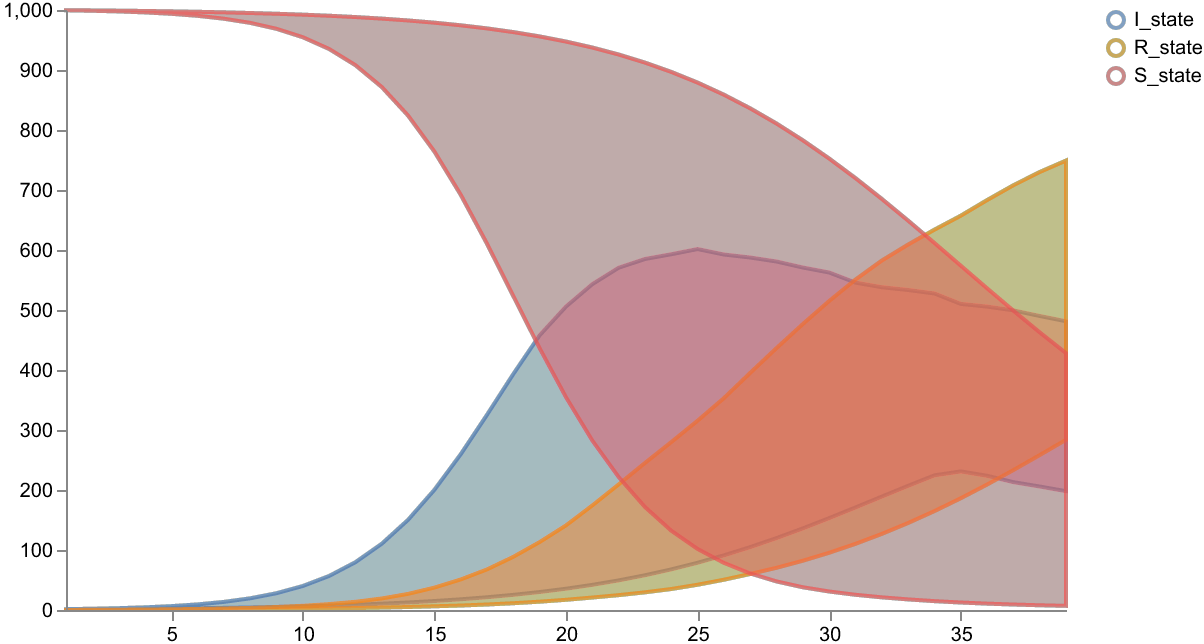

In [12]:
start_t = time.time()
sample_results1 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print("Time taken: ", time.time()-start_t)
# display(sample_results1["data"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2

Time taken:  4.829919099807739


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.202474,0.519406,0.370943,0.197720,0.062425,14.149166,0.006679,38.625103,1.079895,17.926586,4.916286,19339978.0,17.926586,38.625103,1.079895,0.006679
1,1,0,2.0,0.202474,0.519406,0.370943,0.197720,0.062425,14.149166,0.026983,38.957218,2.167301,20.454033,10.953390,19339968.0,20.454033,38.957218,2.167301,0.026983
2,2,0,3.0,0.202474,0.519406,0.370943,0.197720,0.062425,14.149166,0.060572,40.216045,3.202430,22.379719,17.841408,19339956.0,22.379719,40.216045,3.202430,0.060572
3,3,0,4.0,0.202474,0.519406,0.370943,0.197720,0.062425,14.149166,0.106653,42.007870,4.167369,24.035366,25.444172,19339944.0,24.035366,42.007870,4.167369,0.106653
4,4,0,5.0,0.202474,0.519406,0.370943,0.197720,0.062425,14.149166,0.164343,44.135864,5.063378,25.591778,33.696281,19339932.0,25.591778,44.135864,5.063378,0.164343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.319522,0.259579,0.116496,0.034702,0.065870,3.177836,0.741389,272.180786,4.995259,346.131744,462.553375,19338956.0,346.131744,272.180786,4.995259,0.741389
3896,35,99,36.0,0.319522,0.259579,0.116496,0.034702,0.065870,3.177836,0.809905,294.875977,5.411943,374.994141,504.049988,19338862.0,374.994141,294.875977,5.411943,0.809905
3897,36,99,37.0,0.319522,0.259579,0.116496,0.034702,0.065870,3.177836,0.884135,319.463287,5.863345,406.263031,549.006836,19338760.0,406.263031,319.463287,5.863345,0.884135
3898,37,99,38.0,0.319522,0.259579,0.116496,0.034702,0.065870,3.177836,0.964558,346.100464,6.352364,440.139038,597.712402,19338650.0,440.139038,346.100464,6.352364,0.964558


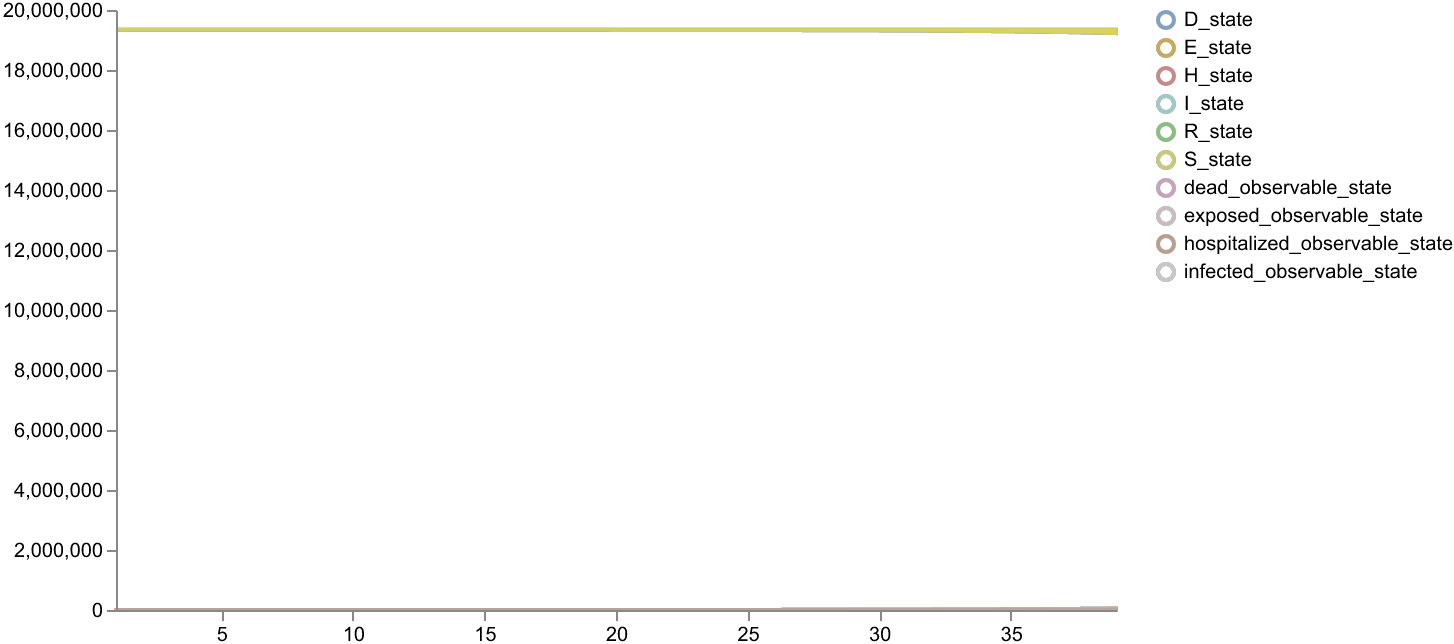

In [13]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    # solver_method="dopri5",
    solver_method="rk4",
    solver_options={"step_size": 0.5}
)
print("Time taken: ", time.time()-start_t)
# display(sample_results2["data"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

## Optimize interface with single intervention
### Optimizing a single parameter value (SIR)
Minimum change in the intervention parameter from the current value to get infections below 300 individuals at 40 days for SIR model

In [14]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 0.1},
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))

 55%|█████▌    | 11/20 [28:45<23:31, 156.83s/it]


KeyboardInterrupt: 

#### Sample using optimal policy as intervention

In [ ]:
result1 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
# display(result1["data"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result1["risk"][observed_params]["risk"])

{1.0: {'p_cbeta': tensor([0.2237])}}


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.314054,19.060932,1.261276,0.052463,999.686279
1,1,0,2.0,0.314054,19.060932,1.476883,0.118634,999.404480
2,2,0,3.0,0.314054,19.060932,1.729253,0.196116,999.074646
3,3,0,4.0,0.314054,19.060932,2.024620,0.286839,998.688538
4,4,0,5.0,0.314054,19.060932,2.370264,0.393057,998.236694
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.390894,9.445127,48.182121,46.284496,906.533569
3896,35,99,36.0,0.390894,9.445127,52.842022,51.385765,896.772400
3897,36,99,37.0,0.390894,9.445127,57.837330,56.980400,886.182434
3898,37,99,38.0,0.390894,9.445127,63.167980,63.103909,874.728271


### Optimizing the start time for a single intervention (SIR)
Maximum delay in the intervention to get infections below 300 individuals at 40 days for SIR model

In [ ]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 5.
bounds_interventions = [[1.], [39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 0.1},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

22it [29:15, 79.78s/it]                          

Optimal policy: tensor([12.2078], dtype=torch.float64)
{'policy': tensor([12.2078], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -12.207774147294181
                          x: [ 1.221e+01]
                        nit: 1
      minimization_failures: 2
                       nfev: 20
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -12.207774147294181
                                   x: [ 1.221e+01]
                                nfev: 10
                               maxcv: 0.0}


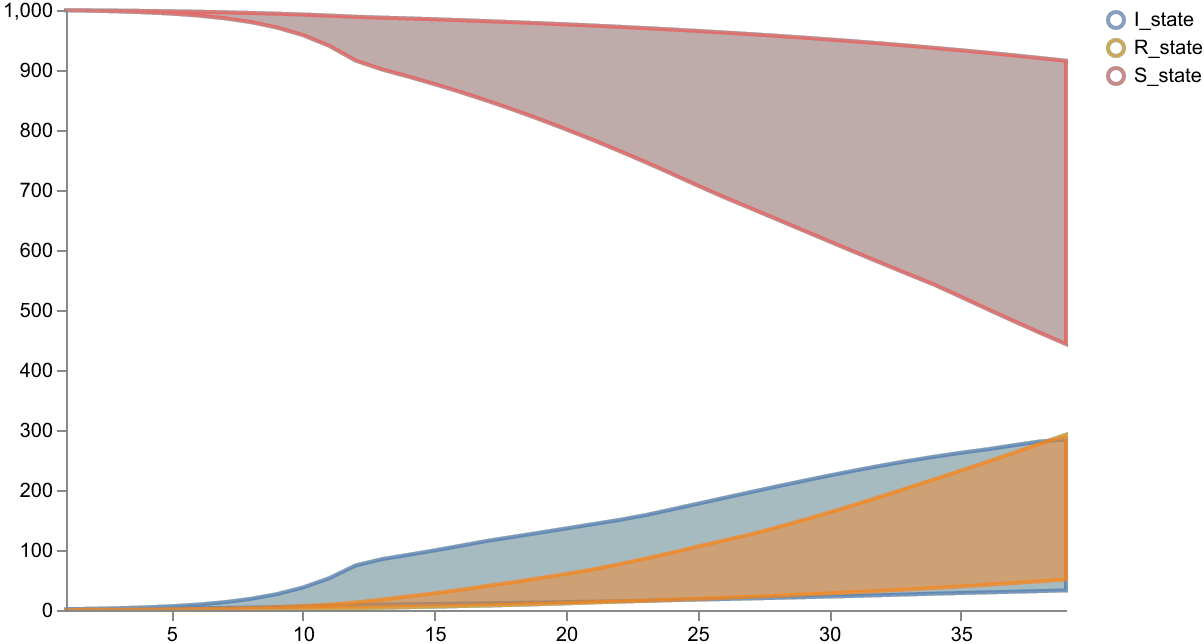

In [ ]:
result2 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
    solver_options={"step_size": 0.1},
)
# display(result2["data"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result2["risk"][observed_params]["risk"])

## Optimize interface with multiple interventions
### Optimizing multiple intervention values (SEIRHD)
Minimum change in two intervention parameters from their current values to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [ ]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.3, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass in lambda x: torch.tensor([x]) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 800.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f"Optimal policy:", opt_result3["policy"])
print(opt_result3)
print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))

  5%|▌         | 1/20 [02:18<43:59, 138.93s/it]

KeyboardInterrupt: 

#### Sample using optimal policy as intervention

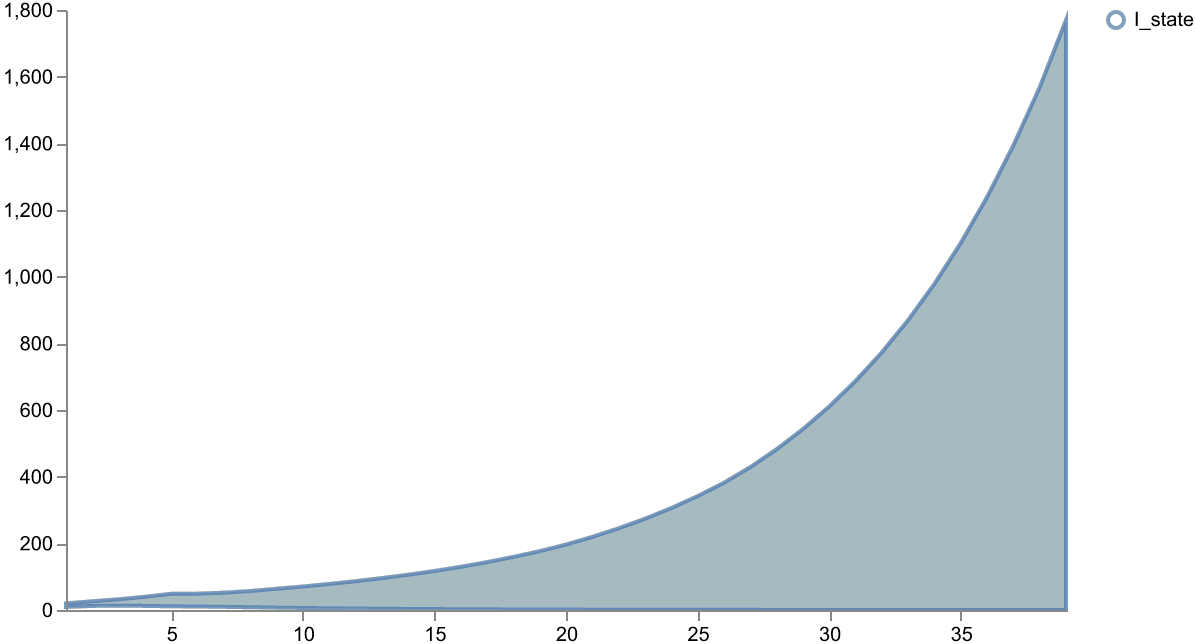

In [ ]:
with pyro.poutine.seed(rng_seed=0):
    result3 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )
# display(result3["data"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result3["risk"][observed_params]["risk"])

### Optimizing for start times of multiple interventions (SEIRHD)
Maximum delay in starting two interventions to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c to be 0.15
* Intervene on gamma to be 0.35

In [ ]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(10.), torch.tensor(10.)]
bounds_interventions = [[10., 10.], [30., 30.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15, 0.4])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 800.
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result4 = pyciemss.optimize(
    model_opt2,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result4["policy"])
print(opt_result4)
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))

 40%|████      | 8/20 [23:53<33:17, 166.44s/it]  

ValueError: Interruption <chirho.dynamical.internals.solver.Interruption object at 0x0000025B5B50F5E0> with time -0.06143200397491455 occurred before the start of the timespan (0.0, 40.0).This interruption will have no effect.
                               Trace Shapes:  
                                Param Sites:  
numeric_initial_state_func$$$_nodes.2._value  
numeric_initial_state_func$$$_nodes.3._value  
numeric_initial_state_func$$$_nodes.4._value  
numeric_initial_state_func$$$_nodes.5._value  
                               Sample Sites:  
                      persistent_beta_c dist |
                                       value |
                       persistent_kappa dist |
                                       value |
                       persistent_gamma dist |
                                       value |
                        persistent_hosp dist |
                                       value |
                  persistent_death_hosp dist |
                                       value |
                          persistent_I0 dist |
                                       value |

Time taken:  8.19417405128479


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.005790,35.812138,0.629191,13.241706,3.086475e+00,19339986.0,13.241706,35.812138,0.629191,0.005790
1,1,0,2.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.023399,34.249908,1.389908,16.789696,7.463374e+00,19339980.0,16.789696,34.249908,1.389908,0.023399
2,2,0,3.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.053980,34.177589,2.177957,19.212952,1.274802e+01,19339970.0,19.212952,34.177589,2.177957,0.053980
3,3,0,4.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.097523,34.962692,2.944097,21.042341,1.872584e+01,19339960.0,21.042341,34.962692,2.944097,0.097523
4,4,0,5.0,0.150000,0.468834,0.350000,0.187064,0.086471,7.620363,0.154730,36.291584,3.663729,22.557556,2.533261e+01,19339950.0,22.557556,36.291584,3.663729,0.154730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,77022.390625,677628.625000,275797.750000,809046.000000,7.450660e+06,10049882.0,809046.000000,677628.625000,275797.750000,77022.390625
9896,95,99,96.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,81753.476562,567187.187500,261043.046875,700175.187500,7.725225e+06,10004652.0,700175.187500,567187.187500,261043.046875,81753.476562
9897,96,99,97.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,86217.148438,474973.343750,244174.218750,601874.500000,7.967242e+06,9965555.0,601874.500000,474973.343750,244174.218750,86217.148438
9898,97,99,98.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,90333.523438,399840.031250,225935.484375,516264.781250,8.174934e+06,9932728.0,516264.781250,399840.031250,225935.484375,90333.523438


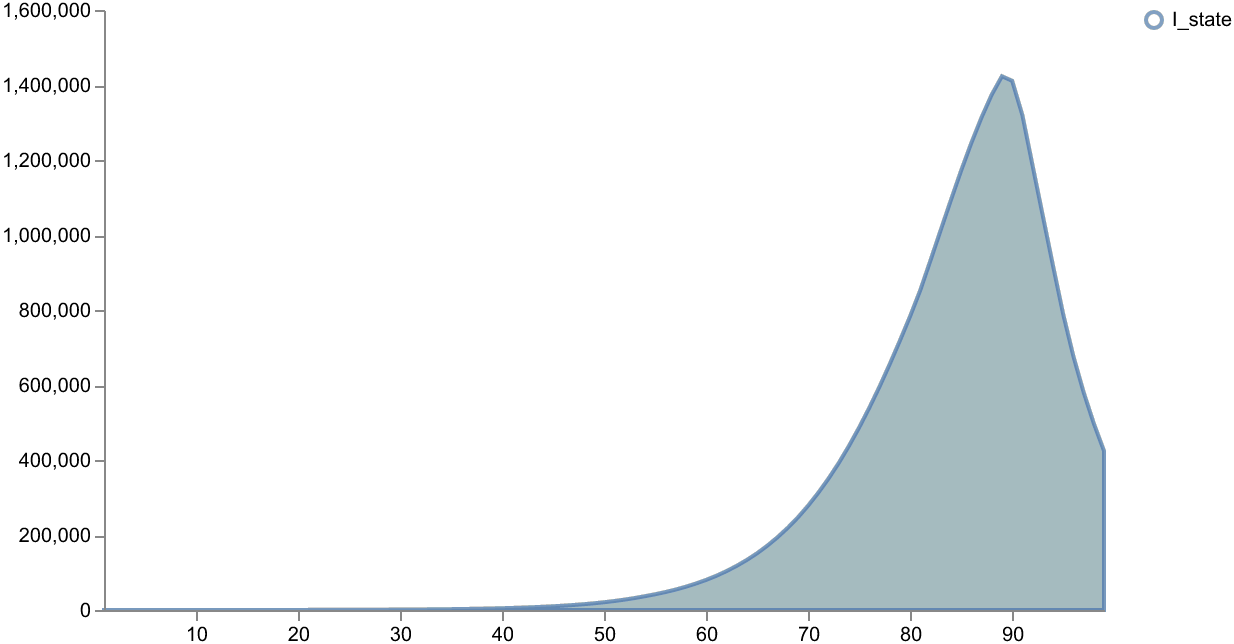

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="rk4",
        # solver_method="euler",
        solver_options={"step_size":1.},
    )
print("Time taken: ", time.time()-start_t)
# display(result4["data"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params]["risk"])

Time taken:  8.754577875137329


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.000401,35.022633,0.347615,15.055376,2.281618,19339988.0,15.055376,35.022633,0.347615,0.000401
1,1,0,2.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.002079,33.224503,0.807116,19.599751,5.804692,19339978.0,19.599751,33.224503,0.807116,0.002079
2,2,0,3.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.005284,33.259682,1.304054,22.958223,10.228070,19339968.0,22.958223,33.259682,1.304054,0.005284
3,3,0,4.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.010082,34.387726,1.803558,25.722313,15.370486,19339958.0,25.722313,34.387726,1.803558,0.010082
4,4,0,5.0,0.150000,0.395880,0.350000,0.141744,0.015949,8.265465,0.016462,36.204086,2.291641,28.224468,21.141350,19339948.0,28.224468,36.204086,2.291641,0.016462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.208786,1096.966431,312.458801,1281.773193,18390.800781,19318934.0,1281.773193,1096.966431,312.458801,19.208786
9896,95,99,96.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.917933,926.298035,295.937378,1113.679565,18831.251953,19318848.0,1113.679565,926.298035,295.937378,19.917933
9897,96,99,97.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,20.586340,783.916748,276.983704,962.387268,19217.660156,19318774.0,962.387268,783.916748,276.983704,20.586340
9898,97,99,98.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,21.209364,664.521973,256.629974,828.412659,19554.992188,19318710.0,828.412659,664.521973,256.629974,21.209364


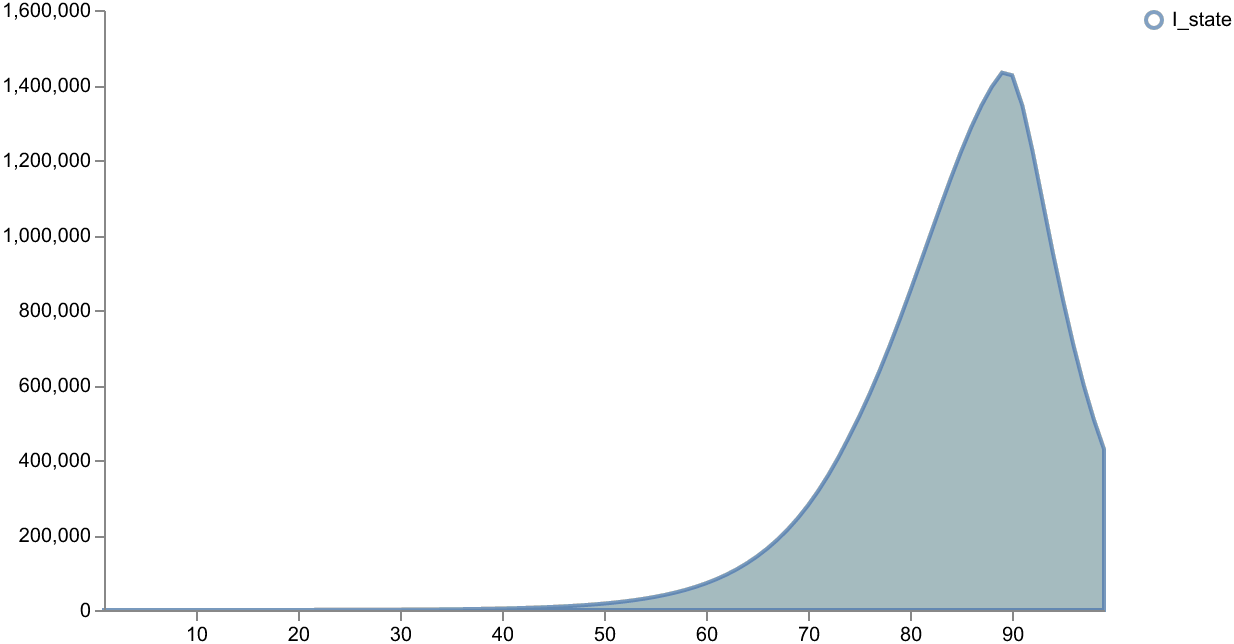

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="euler",
        solver_options={"step_size": 0.1},
    )
print("Time taken: ", time.time()-start_t)
# display(result4["data"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params]["risk"])

Time taken:  16.12155294418335


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.006537,35.195354,0.838740,15.583101,4.126128,19339988.0,15.583101,35.195354,0.838740,0.006537
1,1,0,2.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.027022,32.389149,1.720320,17.855694,9.369328,19339978.0,17.855694,32.389149,1.720320,0.027022
2,2,0,3.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.061201,30.680210,2.541366,18.979063,15.257811,19339972.0,18.979063,30.680210,2.541366,0.061201
3,3,0,4.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.107720,29.574734,3.260566,19.474323,21.519539,19339978.0,19.474323,29.574734,3.260566,0.107720
4,4,0,5.0,0.150000,0.333112,0.350000,0.185165,0.079923,11.210128,0.164840,28.802074,3.867827,19.627031,27.994497,19339960.0,19.627031,28.802074,3.867827,0.164840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.584401,18.269659,2.709901,22.405989,894.369629,19339110.0,22.405989,18.269659,2.709901,0.584401
9896,95,99,96.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.592176,15.260543,2.527707,19.297033,901.831299,19339110.0,19.297033,15.260543,2.527707,0.592176
9897,96,99,97.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.599391,12.771304,2.334918,16.531406,908.276794,19339110.0,16.531406,12.771304,2.334918,0.599391
9898,97,99,98.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.606029,10.704046,2.138563,14.106043,913.817993,19339110.0,14.106043,10.704046,2.138563,0.606029


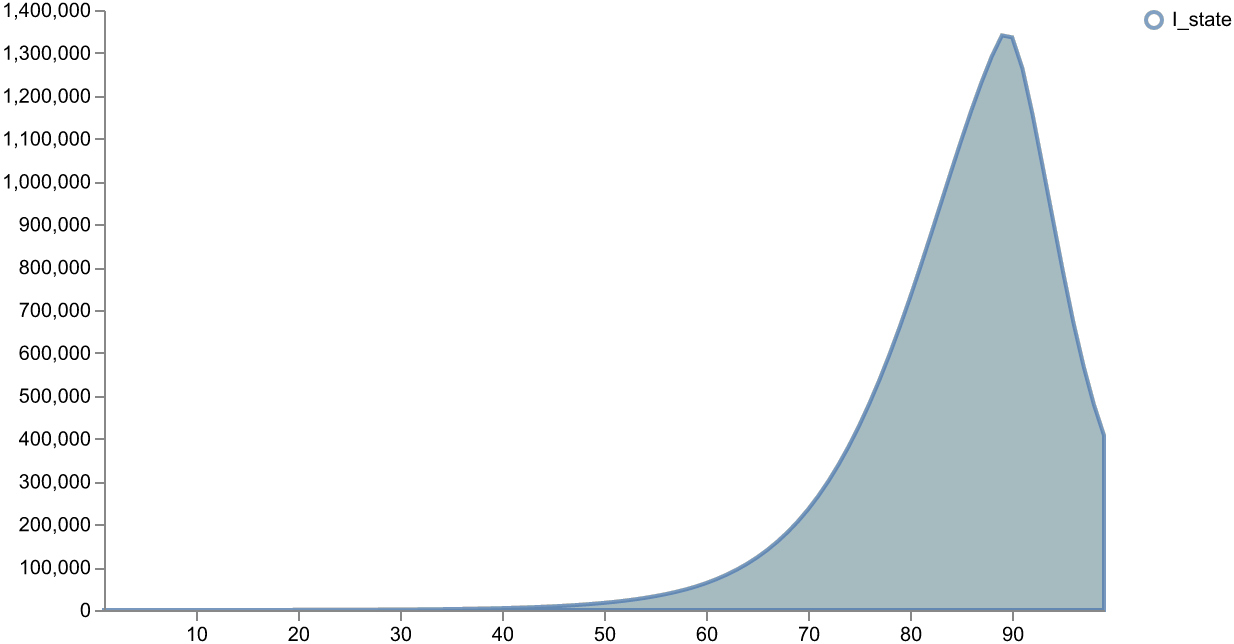

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="dopri5",
    )
print("Time taken: ", time.time()-start_t)
# display(result4["data"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state")
plots.ipy_display(schema, dpi=150)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params]["risk"])